In [1]:
import os
import json

import numpy as np
import pandas as pd
import pennylane as qml

In [2]:
import git
repo = git.Repo('.', search_parent_directories=True)
repo_path = repo.working_tree_dir

<>:135: SyntaxWarning: invalid escape sequence '\k'
<>:135: SyntaxWarning: invalid escape sequence '\k'
C:\Users\Johnk\AppData\Local\Temp\ipykernel_5092\2205153107.py:135: SyntaxWarning: invalid escape sequence '\k'
  "Basis State": "$\ket{" + "".join(str(num) for num in basis_state) + "}$",


########################################################################
Finding optimal circuit for AHO - cutoff 16
########################################################################
Finding optimal circuit for AHO - cutoff 2
########################################################################
Finding optimal circuit for AHO - cutoff 32
########################################################################
Finding optimal circuit for AHO - cutoff 4
########################################################################
Finding optimal circuit for AHO - cutoff 64
########################################################################
Finding optimal circuit for AHO - cutoff 8


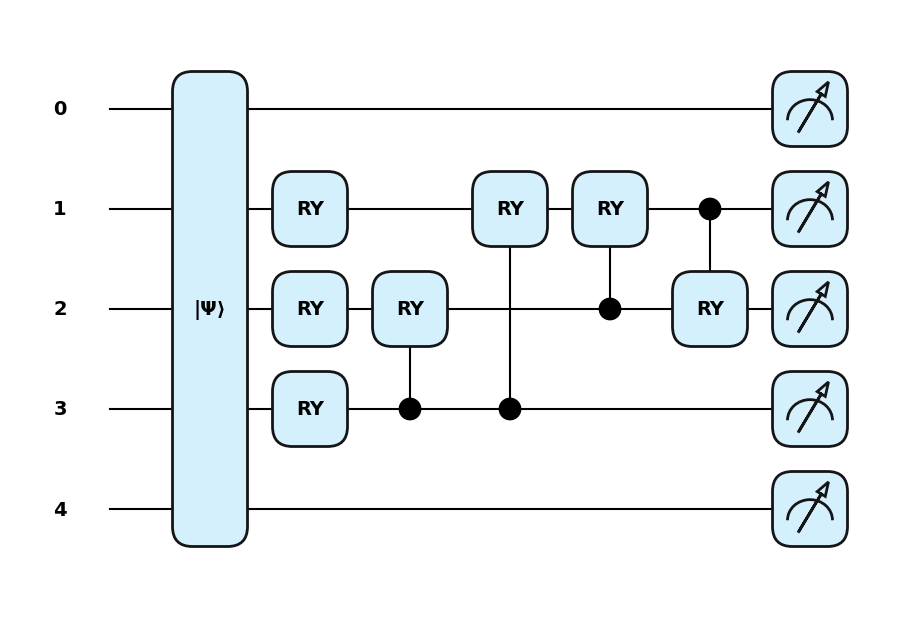

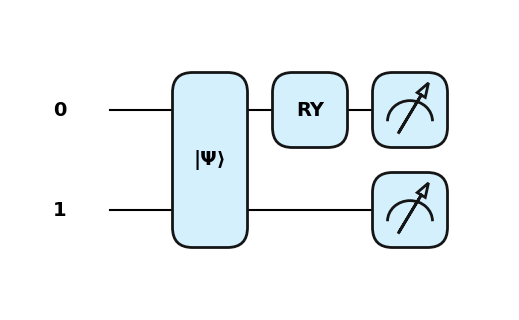

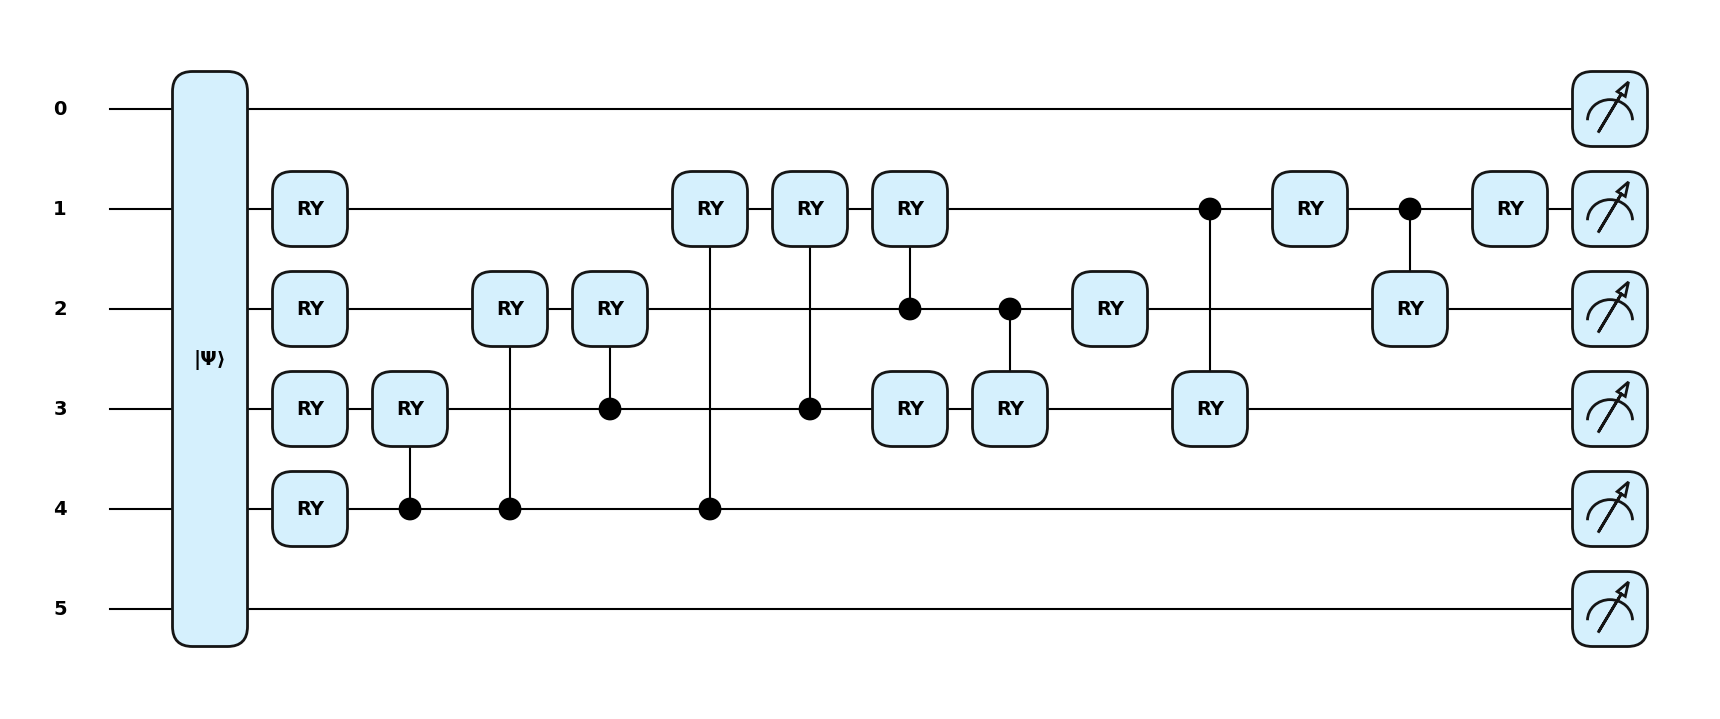

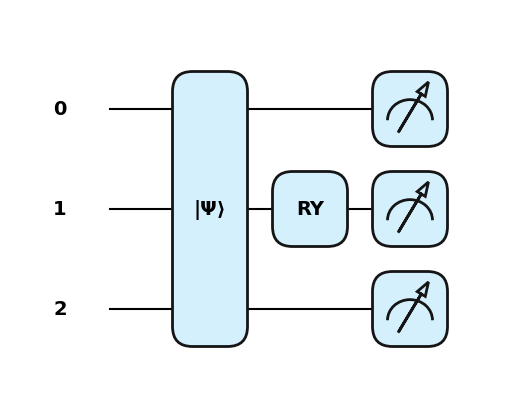

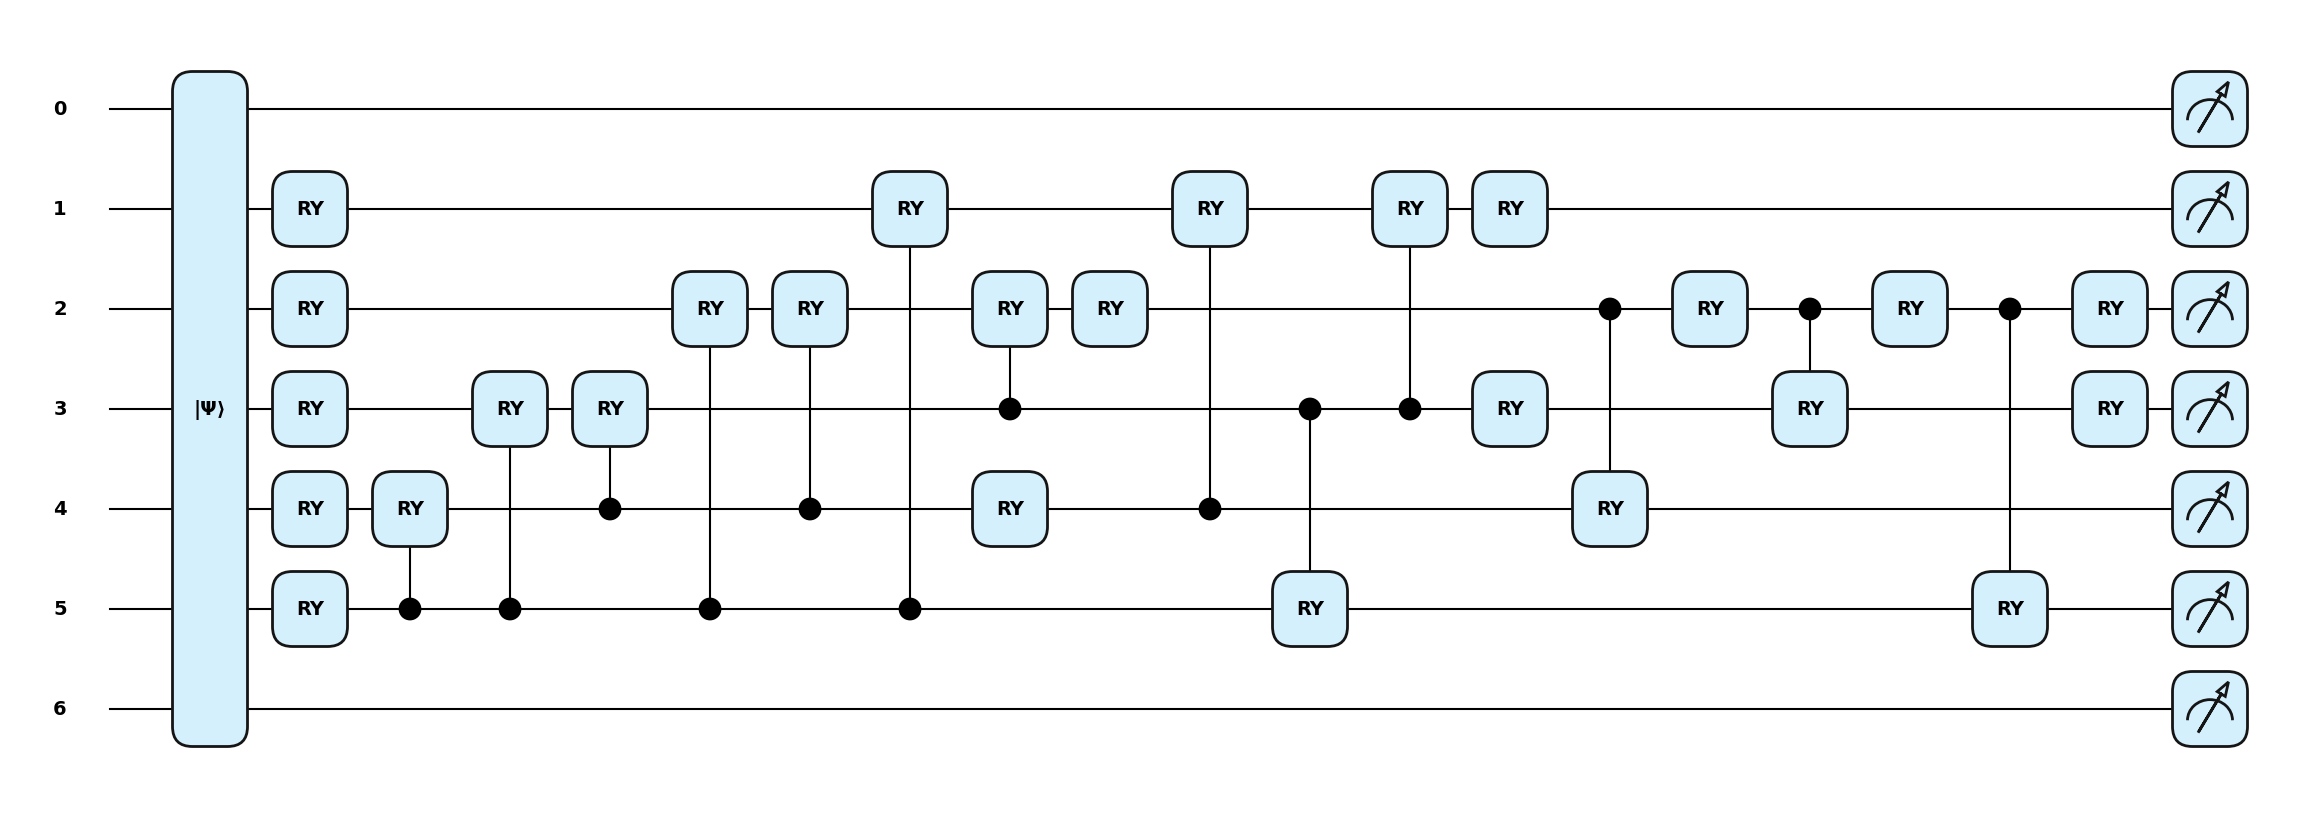

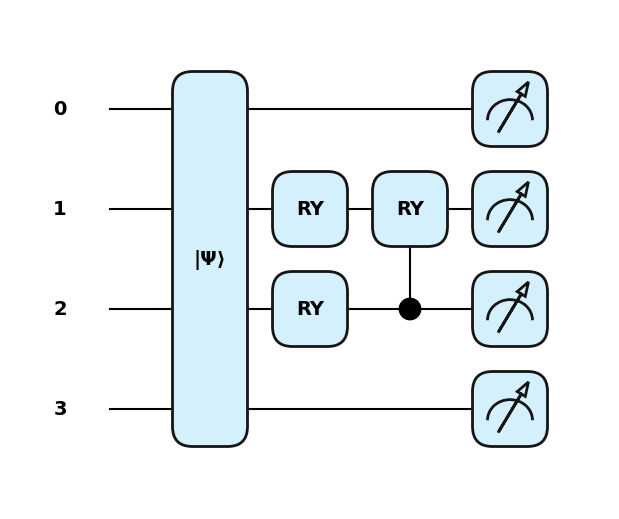

In [3]:
#potentials = ['QHO', 'AHO', 'DW']
potentials = ['AHO']
all_data = []

for potential in potentials:

    folder_path = os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\qml.expval\Adaptive-VQE\StatevectorFiles\{}".format(potential))
    file_paths = os.listdir(folder_path)
    json_files = [f for f in file_paths if f.endswith('.json')]
    #json_files = ['AHO_8.json']

    for file in json_files:
        
        data_path = os.path.join(folder_path,file)
        data_dict = {}

        with open(data_path, 'r') as file:
                data = json.load(file)

        cutoff = data['cutoff']
        potential = data['potential']
        energies = data['all_energies']

        print("########################################################################")
        print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

        num_qubits = int(np.log2(cutoff)) + 1
        min_eigenvalue = min(data['exact_eigenvalues'])

        closest_e = np.inf
        best_index = 0
        gate_length = np.inf
        best_energy_value = None
        best_gate_position = None

        for i, e1 in enumerate(energies):
            for g_idx, e2 in enumerate(e1, start=1):  
                ediff = abs(e2 - min_eigenvalue)

                if ediff < closest_e or ((np.abs(ediff - closest_e) < 1e-6) and g_idx < gate_length):
                    closest_e = ediff
                    best_index = i
                    gate_length = g_idx
                    best_energy_value = e2
                    best_gate_position = g_idx


        best_gate_set = data['op_list'][best_index]
        best_gate_set_reduced = data['op_list'][best_index][:best_gate_position]

        best_energy_list = energies[best_index]
        best_energy_list_reduced = energies[best_index][:best_gate_position]
        energy_diffs = [abs(x - min_eigenvalue) for x in best_energy_list_reduced]
        energy_change = [0.0] + [abs(best_energy_list_reduced[i]-best_energy_list_reduced[i-1]) for i in range(1, len(best_energy_list_reduced))]

        '''
        print(f"Exact eigenvalue: {min_eigenvalue}")
        print(f"Closest energy: {best_energy_value}")
        print(f"Gate sequence: {best_gate_set}")
        print(f"Gates needed to reach best energy: {best_gate_position}")
        print(f"Reduced circuit: {best_gate_set_reduced}")
        print(f"Energy list for best circuit: {best_energy_list_reduced}")
        '''

        basis_state = data["basis_state"]
        best_circuit = best_gate_set[:best_gate_position]

        data_dict = {}
        data_dict['potential'] = potential
        data_dict['cutoff'] = cutoff
        data_dict['basis_state'] = basis_state
        data_dict['min_eigenvalue'] = min_eigenvalue
        data_dict['best_energy_value'] = best_energy_value
        data_dict['best_energy_list_reduced'] = best_energy_list_reduced
        data_dict['energy_diffs'] = energy_diffs
        data_dict['energy_change'] = energy_change
        data_dict['circuit'] = best_circuit

        file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

        with open(file_path, "w") as file:
            json.dump(data_dict, file, indent=4)

        dev = qml.device("default.qubit", wires=num_qubits)
        @qml.qnode(dev)
        def circuit():

            qml.BasisState(basis_state, wires=range(num_qubits))

            for op_dict in best_circuit:
                op = getattr(qml, op_dict["name"])
                op(op_dict['param'], wires=op_dict['wires'])

            return qml.state()

        circuit_diagram = qml.draw(circuit)()
        mpl_diagram, ax = qml.draw_mpl(circuit, style='pennylane')()

        diagram_path = os.path.join(folder_path, "circuitDiagrams")
        os.makedirs(diagram_path, exist_ok=True)
        mpl_diagram.savefig(diagram_path + f"\\{potential}_{cutoff}.png")


        with open(file_path, "a", encoding="utf-8") as file:
            file.write("\n###############################\n")
            file.write(circuit_diagram)
            file.write("\n###############################\n")



        op_labels = ""
        counter = 0
        params = []
        for op_dict in best_circuit:

            gate = op_dict["name"]
            params.append(op_dict["param"])
            wires = op_dict["wires"]

            qiskit_wires = [f"$q_{(num_qubits - 1) - w}$" for w in wires]
            label = f"{gate}[{', '.join(qiskit_wires)}]"

            if counter == 0:
                op_labels = label
            else:
                op_labels = op_labels + ", " + label

            counter +=1


        num_gates = len(best_circuit)

        dd = {"Potential": potential,
            r"$\Lambda$": cutoff,
            "Basis State": "$\ket{" + "".join(str(num) for num in basis_state) + "}$",
            r"$N_\text{gates}$": num_gates,
            "Ansatz":op_labels,
            #"params":params,
            r"$E_{\text{VQE}}$": best_energy_value,
            r"$E_{\text{Exact}}$": min_eigenvalue,
            }

        all_data.append(dd)

In [4]:
pd.options.display.float_format = "{:.6e}".format
pd.set_option("display.max_colwidth", None)

In [5]:
df = pd.DataFrame(all_data).sort_values(['Potential','$\Lambda$'])
df

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Johnk\AppData\Local\Temp\ipykernel_3008\272004684.py:1: SyntaxWarning: invalid escape sequence '\L'
  df = pd.DataFrame(all_data).sort_values(['Potential','$\Lambda$'])


,Potential,$\Lambda$,Basis State,$N_\text{gates}$,Ansatz,$E_{\text{VQE}}$,$E_{\text{Exact}}$
6,AHO,2,$\ket{10}$,1,RY[$q_1$],-4.375000e-01,-4.375000e-01
8,AHO,4,$\ket{100}$,1,RY[$q_1$],-1.647853e-01,-1.647853e-01
10,AHO,8,$\ket{1000}$,3,"RY[$q_2$], RY[$q_1$], CRY[$q_1$, $q_2$]",3.201011e-02,3.201011e-02
5,AHO,16,$\ket{10000}$,7,"RY[$q_2$], RY[$q_3$], RY[$q_1$], CRY[$q_1$, $q_2$], CRY[$q_1$, $q_3$], CRY[$q_2$, $q_3$], CRY[$q_3$, $q_2$]",-1.166976e-03,-1.166976e-03
7,AHO,32,$\ket{100000}$,24,"RY[$q_2$], RY[$q_3$], RY[$q_1$], CRY[$q_1$, $q_2$], CRY[$q_1$, $q_3$], RY[$q_4$], CRY[$q_2$, $q_3$], CRY[$q_1$, $q_4$], CRY[$q_2$, $q_4$], CRY[$q_3$, $q_4$], CRY[$q_5$, $q_2$], CRY[$q_3$, $q_2$], CRY[$q_5$, $q_3$], CRY[$q_4$, $q_2$], CRY[$q_5$, $q_4$], RY[$q_4$], CRY[$q_4$, $q_3$], RY[$q_4$], RY[$q_2$], RY[$q_3$], CRY[$q_2$, $q_1$], RY[$q_2$], CRY[$q_3$, $q_1$], RY[$q_3$]",6.187663e-06,6.182238e-06
9,AHO,64,$\ket{1000000}$,28,"RY[$q_2$], RY[$q_3$], RY[$q_1$], CRY[$q_1$, $q_2$], CRY[$q_1$, $q_3$], RY[$q_4$], CRY[$q_2$, $q_3$], CRY[$q_1$, $q_4$], RY[$q_5$], CRY[$q_2$, $q_4$], CRY[$q_1$, $q_5$], CRY[$q_3$, $q_4$], CRY[$q_6$, $q_2$], CRY[$q_2$, $q_5$], CRY[$q_6$, $q_1$], CRY[$q_3$, $q_2$], CRY[$q_3$, $q_5$], CRY[$q_6$, $q_3$], CRY[$q_6$, $q_5$], CRY[$q_6$, $q_4$], RY[$q_5$], CRY[$q_4$, $q_2$], RY[$q_4$], CRY[$q_4$, $q_3$], RY[$q_4$], RY[$q_3$], CRY[$q_4$, $q_1$], RY[$q_4$]",1.912520e-05,-1.944061e-08
12,DW,2,$\ket{00}$,1,RY[$q_0$],3.572330e-01,3.572330e-01
14,DW,4,$\ket{100}$,3,"RY[$q_1$], RY[$q_0$], CRY[$q_1$, $q_0$]",9.065599e-01,9.065599e-01
16,DW,8,$\ket{0000}$,7,"RY[$q_0$], CRY[$q_0$, $q_1$], RY[$q_2$], RY[$q_1$], CRY[$q_0$, $q_2$], CRY[$q_1$, $q_2$], RY[$q_1$]",8.845804e-01,8.845804e-01
11,DW,16,$\ket{00000}$,18,"RY[$q_0$], CRY[$q_0$, $q_1$], RY[$q_2$], RY[$q_1$], RY[$q_3$], CRY[$q_0$, $q_2$], CRY[$q_0$, $q_3$], CRY[$q_1$, $q_2$], RY[$q_1$], CRY[$q_1$, $q_3$], CRY[$q_2$, $q_3$], RY[$q_1$], CRY[$q_2$, $q_1$], RY[$q_2$], CRY[$q_3$, $q_2$], RY[$q_3$], CRY[$q_3$, $q_1$], RY[$q_2$]",8.915994e-01,8.915994e-01


In [6]:
df.to_latex(os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\qml.expval\Adaptive-VQE\StatevectorFiles", "tab.tex"), index=False)